In [83]:
import pandas as pd
import pandas_datareader as pdr

In [177]:
df = pdr.get_data_tiingo('FB',api_key='f51e609e2673d86515fbc83f51851c569a46a414')

In [178]:
df.to_csv('FB.csv')

In [179]:
df = pd.read_csv('FB.csv')

In [180]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,FB,2021-10-28 00:00:00+00:00,316.92,325.5200,308.11,312.99,50806840,316.92,325.5200,308.11,312.99,50806840,0.0,1.0
1253,FB,2021-10-29 00:00:00+00:00,323.57,325.9999,319.60,320.19,37059384,323.57,325.9999,319.60,320.19,37059384,0.0,1.0
1254,FB,2021-11-01 00:00:00+00:00,329.98,333.4500,326.00,326.04,31164440,329.98,333.4500,326.00,326.04,31164440,0.0,1.0
1255,FB,2021-11-02 00:00:00+00:00,328.08,334.7895,323.80,331.38,28259036,328.08,334.7895,323.80,331.38,28259036,0.0,1.0
1256,FB,2021-11-03 00:00:00+00:00,331.62,332.1500,323.20,327.49,20786502,331.62,332.1500,323.20,327.49,20786502,0.0,1.0


In [181]:
df1 = df.reset_index()['close']
df1.shape

(1257,)

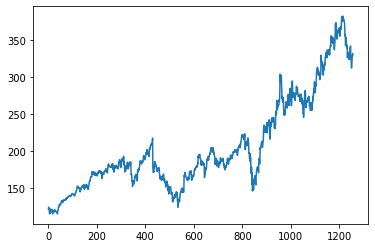

In [182]:
import matplotlib.pyplot as plt
plt.plot(df1)

## LSTM is sensitive to the scale of the data. So we apply MinMax scaler

In [183]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[0.02657882],
       [0.03432786],
       [0.03043462],
       ...,
       [0.80458953],
       [0.79747688],
       [0.81072886]])

### Splitting the data into train test split

In [184]:
train_size = int(len(df1)*0.65)
test_size = len(df1) - train_size
train_data,test_data = df1[0:train_size,:],df1[train_size:len(df1),:1]
train_data.shape
test_data.shape

(440, 1)

### Now using the train and test data, we split it into X and Y (predictor and target features)

In [185]:
def create_dataset(dataset,time_step = 1):
  dataX, dataY = [],[]
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX),np.array(dataY)


In [186]:
time_step = 100
X_train, y_train = create_dataset(train_data,time_step)
X_test, y_test = create_dataset(test_data,time_step)

In [187]:
print(X_train)

[[0.02657882 0.03432786 0.03043462 ... 0.10332048 0.10242204 0.10107438]
 [0.03432786 0.03043462 0.0215251  ... 0.10242204 0.10107438 0.10193539]
 [0.03043462 0.0215251  0.01486168 ... 0.10107438 0.10193539 0.09987646]
 ...
 [0.26623741 0.27492232 0.27110396 ... 0.40497136 0.35368547 0.32516003]
 [0.27492232 0.27110396 0.27005578 ... 0.35368547 0.32516003 0.3336952 ]
 [0.27110396 0.27005578 0.26642459 ... 0.32516003 0.3336952  0.35480852]]


In [188]:
print(X_train.shape),print(y_train.shape)
print(X_test.shape),print(y_test.shape)

(716, 100)
(716,)
(339, 100)
(339,)


(None, None)

In [189]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

## Create Stacked LSTM Model

In [190]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [191]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape = (100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer = 'adam')

In [192]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
lstm_16 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_17 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [193]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 9s 308ms/step - loss: 0.0124 - val_loss: 0.0924
Epoch 2/100
12/12 [==============================] - 2s 206ms/step - loss: 0.0028 - val_loss: 0.0235
Epoch 3/100
12/12 [==============================] - 2s 203ms/step - loss: 0.0020 - val_loss: 0.0436
Epoch 4/100
12/12 [==============================] - 2s 205ms/step - loss: 0.0014 - val_loss: 0.0345
Epoch 5/100
12/12 [==============================] - 2s 203ms/step - loss: 0.0012 - val_loss: 0.0098
Epoch 6/100
12/12 [==============================] - 2s 205ms/step - loss: 9.7251e-04 - val_loss: 0.0044
Epoch 7/100
12/12 [==============================] - 2s 204ms/step - loss: 8.9926e-04 - val_loss: 0.0031
Epoch 8/100
12/12 [==============================] - 2s 205ms/step - loss: 8.6787e-04 - val_loss: 0.0024
Epoch 9/100
12/12 [==============================] - 2s 205ms/step - loss: 8.4501e-04 - val_loss: 0.0024
Epoch 10/100
12/12 [==============================] - 2s 204ms/step - loss:

In [194]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [195]:
train_pred

array([[0.10424503],
       [0.10511559],
       [0.10507689],
       [0.10456865],
       [0.10360589],
       [0.10235053],
       [0.10133578],
       [0.10014822],
       [0.09880133],
       [0.0974889 ],
       [0.09755299],
       [0.09843644],
       [0.10023981],
       [0.10313195],
       [0.10614805],
       [0.10951737],
       [0.11315486],
       [0.11636535],
       [0.11930183],
       [0.12314184],
       [0.12849513],
       [0.13421111],
       [0.13833193],
       [0.13981827],
       [0.13898264],
       [0.13767017],
       [0.13646334],
       [0.13566652],
       [0.13526443],
       [0.13543439],
       [0.13590619],
       [0.13617773],
       [0.13305667],
       [0.12973037],
       [0.1277485 ],
       [0.12728053],
       [0.12763508],
       [0.12941578],
       [0.13295156],
       [0.13697651],
       [0.14038272],
       [0.14191493],
       [0.1418253 ],
       [0.14221379],
       [0.1432643 ],
       [0.14403734],
       [0.14457409],
       [0.146

In [196]:
# Transforming back to original scale of the data
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

In [197]:
# Evaluating the model performance using RMSE
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_pred))

176.1701921617824

In [198]:
# Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_pred))

296.8747672630491

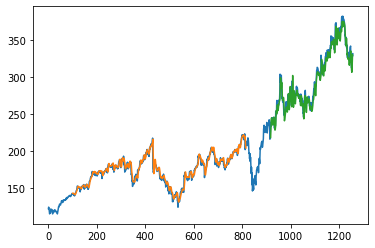

In [214]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_pred)+look_back, :] = train_pred
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_pred)+(look_back*2)+1:len(df1)-1, :] = test_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [220]:
len(test_data)

440

In [221]:
x_input=test_data[340:].reshape(1,-1)
x_input.shape

(1, 100)

In [222]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [223]:
temp_input

[0.829932991427395,
 0.8087073709429866,
 0.829034552465092,
 0.8033916070826941,
 0.8132370007112644,
 0.8384681615692733,
 0.8443080148242428,
 0.8540036686257628,
 0.8472279414517276,
 0.9006476247519934,
 0.886609515966009,
 0.8709617040392319,
 0.8959682551566652,
 0.8971287388163067,
 0.8899412271178826,
 0.8813686220192416,
 0.863250102946131,
 0.8811065773219033,
 0.8913637554748626,
 0.8873582151012616,
 0.870662224385131,
 0.8587953430913786,
 0.8464418073597126,
 0.8306816905626475,
 0.848313555197844,
 0.8654213304383636,
 0.8839890689926253,
 0.9536180885711079,
 0.9636132220267286,
 0.9462059671321081,
 0.9666828884812637,
 0.9106801931643769,
 0.9031183318983267,
 0.8868341257065848,
 0.8841762437764384,
 0.9129262905701345,
 0.9280874480589976,
 0.9301089357241792,
 0.9229962939392806,
 0.9211994160146746,
 0.9168195260734473,
 0.9268895294425934,
 0.9288735821510128,
 0.9415265975367799,
 0.9111668476022909,
 0.8999363605735036,
 0.898701007000337,
 0.9146108636244525,

In [224]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<10):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.7979014]
101
1 day input [0.80870737 0.82903455 0.80339161 0.813237   0.83846816 0.84430801
 0.85400367 0.84722794 0.90064762 0.88660952 0.8709617  0.89596826
 0.89712874 0.88994123 0.88136862 0.8632501  0.88110658 0.89136376
 0.88735822 0.87066222 0.85879534 0.84644181 0.83068169 0.84831356
 0.86542133 0.88398907 0.95361809 0.96361322 0.94620597 0.96668289
 0.91068019 0.90311833 0.88683413 0.88417624 0.91292629 0.92808745
 0.93010894 0.92299629 0.92119942 0.91681953 0.92688953 0.92887358
 0.9415266  0.91116685 0.89993636 0.89870101 0.91461086 0.92950998
 0.93759593 0.94837719 0.93336578 0.96424962 0.99430989 0.98951821
 0.99951335 0.97416988 0.97783851 1.         0.98274248 0.98435219
 0.9869352  0.97877438 0.97884925 0.96907873 0.96585932 0.93463857
 0.90087223 0.90753566 0.85411597 0.86441059 0.89061506 0.89293602
 0.84453262 0.84063939 0.83981582 0.85336727 0.79055142 0.81574514
 0.81829072 0.80174447 0.80485157 0.78763149 0.78134242 0.78422491
 0.79916146 0.78504848 0.82465466 

In [225]:
day_new=np.arange(1,101)
day_pred=np.arange(101,111)

In [226]:
import matplotlib.pyplot as plt

In [227]:
len(df1)

1257

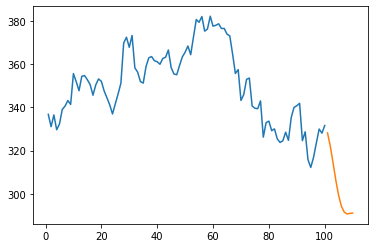

In [228]:
plt.plot(day_new,scaler.inverse_transform(df1[1157:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

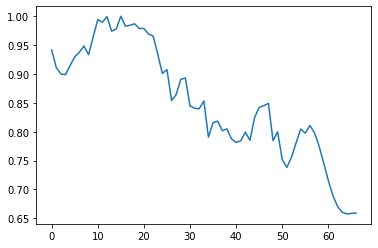

In [229]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

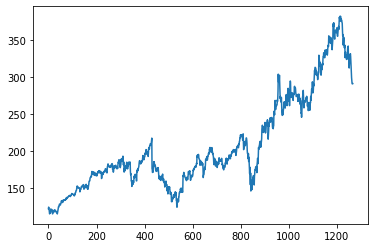

In [230]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)